In [2]:
# 1 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

from xgboost import XGBClassifier
import joblib

sns.set(style="whitegrid")

In [4]:
#  Load Training and Testing Data
train_df = pd.read_csv("customer_churn_dataset-training-master.csv")
test_df = pd.read_csv("customer_churn_dataset-testing-master.csv")

print("Training Data Shape:", train_df.shape)
print("Testing Data Shape:", test_df.shape)
print("\nTraining Data Preview:")
display(train_df.head())


Training Data Shape: (440833, 12)
Testing Data Shape: (64374, 12)

Training Data Preview:


,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [5]:
#  Data Preprocessing
# Drop ID column if present
train_df = train_df.drop(columns=["CustomerID"], errors="ignore")
test_df = test_df.drop(columns=["CustomerID"], errors="ignore")

TARGET = "Churn"
X_train = train_df.drop(columns=[TARGET])
y_train = train_df[TARGET]

X_test = test_df.drop(columns=[TARGET])
y_test = test_df[TARGET]

categorical_cols = ['Gender', 'Subscription Type', 'Contract Length']
numerical_cols = [col for col in X_train.columns if col not in categorical_cols]

print("Categorical Columns:", categorical_cols)
print("Numerical Columns:", numerical_cols)

Categorical Columns: ['Gender', 'Subscription Type', 'Contract Length']
Numerical Columns: ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction']


In [6]:
#  Build Preprocessing and Model Pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    eval_metric='logloss'
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])

In [11]:
#  Fix Target Variable

# Convert categorical churn labels to numeric if necessary
y_train = y_train.replace({'Yes': 1, 'No': 0})
y_test = y_test.replace({'Yes': 1, 'No': 0})

# Drop missing target rows (NaN)
train_valid_idx = y_train.dropna().index
test_valid_idx = y_test.dropna().index

X_train = X_train.loc[train_valid_idx]
y_train = y_train.loc[train_valid_idx]

X_test = X_test.loc[test_valid_idx]
y_test = y_test.loc[test_valid_idx]

# Ensure target is integer type
y_train = y_train.astype(int)
y_test = y_test.astype(int)

print(" Target column cleaned successfully!")
print("Unique classes in y_train:", y_train.unique())


 Target column cleaned successfully!
Unique classes in y_train: [1 0]


 Accuracy: 0.504
 Precision: 0.489
 Recall: 0.998
 F1 Score: 0.656
 ROC-AUC: 0.727

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.06      0.11     33881
           1       0.49      1.00      0.66     30493

    accuracy                           0.50     64374
   macro avg       0.73      0.53      0.38     64374
weighted avg       0.74      0.50      0.37     64374



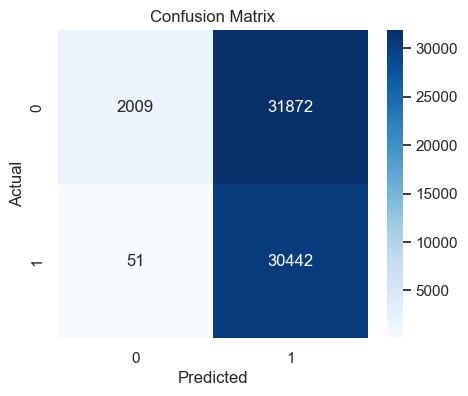

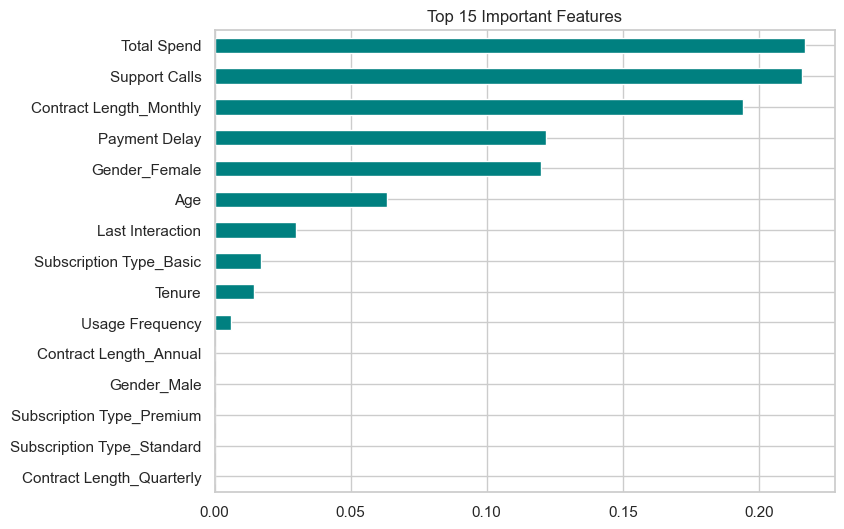

 Model and predictions saved successfully!


In [12]:
#  Train Model
pipeline.fit(X_train, y_train)

#  Predictions & Evaluation
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

print(" Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print(" Precision:", round(precision_score(y_test, y_pred), 3))
print(" Recall:", round(recall_score(y_test, y_pred), 3))
print(" F1 Score:", round(f1_score(y_test, y_pred), 3))
print(" ROC-AUC:", round(roc_auc_score(y_test, y_proba), 3))

print("\nClassification Report:\n", classification_report(y_test, y_pred))

#  Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#  Feature Importance
model = pipeline.named_steps['model']

ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_names = ohe.get_feature_names_out(categorical_cols)
feature_names = np.concatenate([numerical_cols, cat_names])

importances = model.feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(8,6))
feat_imp.head(15).plot(kind='barh', color='teal')
plt.title("Top 15 Important Features")
plt.gca().invert_yaxis()
plt.show()

#  Save Model and Predictions
joblib.dump(pipeline, "customer_churn_xgb_pipeline.joblib")

pred_df = X_test.copy()
pred_df['Actual_Churn'] = y_test.values
pred_df['Predicted_Churn'] = y_pred
pred_df['Churn_Probability'] = y_proba
pred_df.to_excel("customer_churn_predictions.xlsx", index=False)

print(" Model and predictions saved successfully!")
